## Import libraries

In [1]:
import os
import cv2
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns  
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import TFViTModel
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import Permute, Input, Layer, Flatten, Add, LayerNormalization, MultiHeadAttention, Dense, Embedding, Rescaling, Resizing, RandomFlip, RandomRotation, RandomContrast, RandomBrightness, RandomCrop, RandomTranslation, RandomZoom, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import TopKCategoricalAccuracy, CategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Data preparation

In [2]:
train_directory = "/kaggle/input/fer2013/train"
test_directory = "/kaggle/input/fer2013/test"
CLASS_NAMES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

CONFIGURATION = {
    'BATCH_SIZE': 32,
    'IMG_SIZE': 256,
}

In [43]:
# Create dataframe from directories
def create_dataframe_from_directory(directory):
    file_paths = []
    labels = []
    for label, class_name in enumerate(CLASS_NAMES):
        class_directory = os.path.join(directory, class_name)
        for filename in os.listdir(class_directory):
            file_paths.append(os.path.join(class_directory, filename))
            labels.append(class_name)
    data = {'file_paths': file_paths, 'labels': labels}
    return pd.DataFrame(data)

# Create dataframes
train_df = create_dataframe_from_directory(train_directory)
test_df = create_dataframe_from_directory(test_directory)

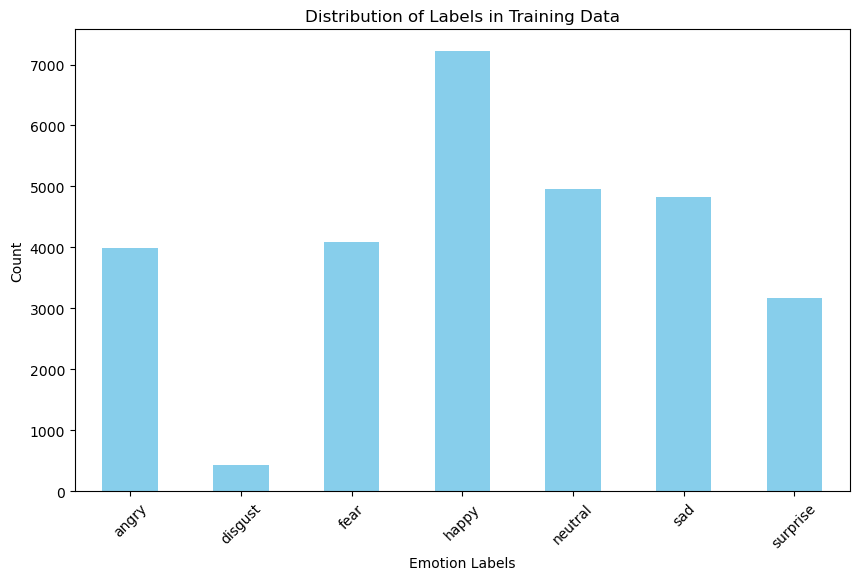

In [44]:
# Plot distribution of labels
plt.figure(figsize=(10, 6))
train_df['labels'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels in Training Data')
plt.xlabel('Emotion Labels')
plt.ylabel('Count')
plt.xticks(ticks=range(len(CLASS_NAMES)), labels=CLASS_NAMES, rotation=45)
plt.show()

In [45]:
# Perform Random Oversampling
oversampler = RandomOverSampler()
X_train_resampled, y_train_resampled = oversampler.fit_resample(train_df[['file_paths']], train_df['labels'])

# Convert oversampled data to DataFrame
balanced_labels_df = pd.concat([X_train_resampled, y_train_resampled], axis=1)

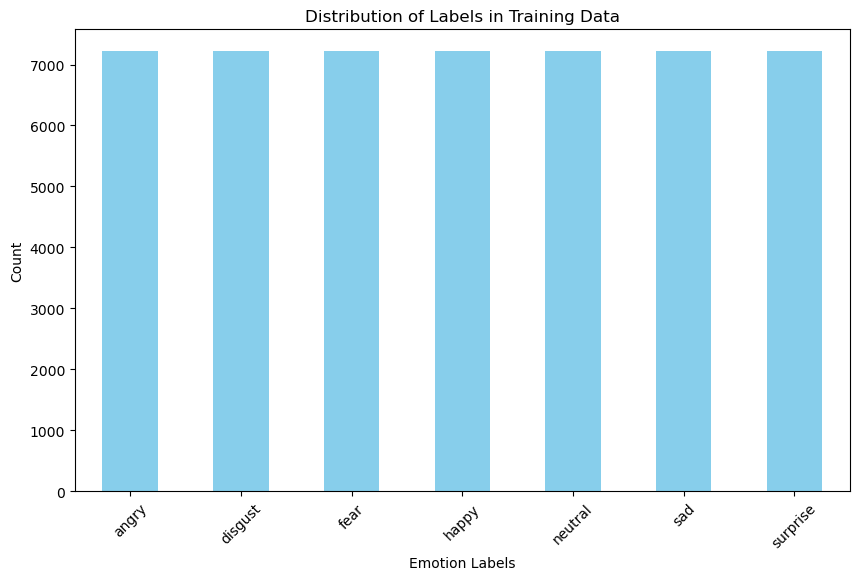

In [46]:
# Plot distribution of labels
plt.figure(figsize=(10, 6))
balanced_labels_df['labels'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels in Training Data')
plt.xlabel('Emotion Labels')
plt.ylabel('Count')
plt.xticks(ticks=range(len(CLASS_NAMES)), labels=CLASS_NAMES, rotation=45)
plt.show()

In [47]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
for train_index, validation_index in sss.split(balanced_labels_df['file_paths'], balanced_labels_df['labels']):
    train_df, validation_df = balanced_labels_df.iloc[train_index], balanced_labels_df.iloc[validation_index]

print("train_df shape: {}".format(train_df.shape))
print("validation_df shape: {}".format(validation_df.shape))

train_df shape: (40404, 2)
validation_df shape: (10101, 2)


In [91]:
train_datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_dataset = train_datagen.flow_from_dataframe(
    train_df,
    directory = train_directory,
    x_col = 'file_paths',
    y_col = 'labels',
    class_mode = 'categorical',
    target_size = (CONFIGURATION['IMG_SIZE'], CONFIGURATION['IMG_SIZE']),
    interpolation="bicubic",
    batch_size = CONFIGURATION['BATCH_SIZE'],
    seed=99, ## Always have the same shuffing
    shuffing=True,
)

validation_datagen = ImageDataGenerator(rescale=1./255)

val_dataset = validation_datagen.flow_from_dataframe(
    validation_df,
    directory = train_directory,
    x_col = 'file_paths',
    y_col = 'labels',
    class_mode = 'categorical',
    target_size = (CONFIGURATION['IMG_SIZE'], CONFIGURATION['IMG_SIZE']),
    interpolation="bicubic",
    batch_size = CONFIGURATION['BATCH_SIZE'],
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_dataset = validation_datagen.flow_from_dataframe(
    test_df,
    directory = test_directory,
    x_col = 'file_paths',
    y_col = 'labels',
    class_mode = 'categorical',
    target_size = (CONFIGURATION['IMG_SIZE'], CONFIGURATION['IMG_SIZE']),
    interpolation="bicubic",
    batch_size = CONFIGURATION['BATCH_SIZE'],
    shuffle=False
)

Found 40404 validated image filenames belonging to 7 classes.
Found 10101 validated image filenames belonging to 7 classes.
Found 7178 validated image filenames belonging to 7 classes.


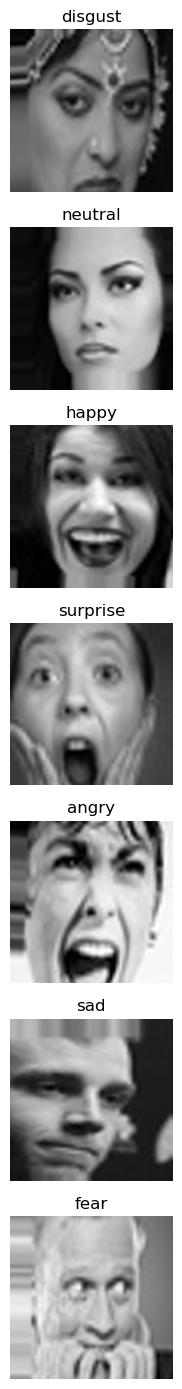

In [92]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images_from_each_class(dataset, class_names):
    class_batch = {}
    for images, labels in dataset:
        for img, label in zip(images, labels):
            class_index = np.argmax(label)
            class_name = class_names[class_index]
            
            if class_name not in class_batch:
                class_batch[class_name] = img
                if len(class_batch) == len(class_names):
                    break
        if len(class_batch) == len(class_names):
            break
    
    # Plotting
    n = len(class_batch)
    plt.figure(figsize=(10, 2 * n))
    for i, (class_name, image) in enumerate(class_batch.items()):
        plt.subplot(n, 1, i + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_images_from_each_class(train_dataset, CLASS_NAMES)


In [93]:
test_image = cv2.imread('/kaggle/input/fer2013/train/happy/Training_10019449.jpg')
test_image = cv2.resize(test_image, (CONFIGURATION['IMG_SIZE'], CONFIGURATION['IMG_SIZE']))

In [94]:
patches = tf.image.extract_patches(images = tf.expand_dims(test_image, axis=0),
                                  sizes=[1,16,16,1],
                                  strides=[1,16,16,1],
                                  rates=[1,1,1,1],
                                  padding='VALID')

In [95]:
print(patches.shape)
patches = tf.reshape(patches, (patches.shape[0], 256, 768))
print(patches.shape)

(1, 16, 16, 768)
(1, 256, 768)


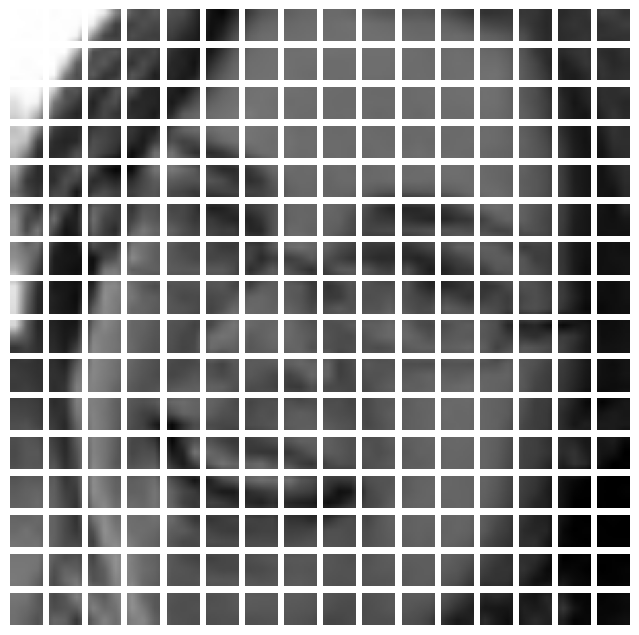

In [96]:
# plt.figure(figsize = (8,8))
# k = 0
# for i in range(16):
#     for j in range(16):
#         ax = plt.subplot(16, 16, k+1)
#         plt.imshow(tf.reshape(patches[0,i,j,:], (16,16,3)))
#         plt.axis("off")
#         k+=1
plt.figure(figsize = (8,8))
for i in range(patches.shape[1]):
        ax = plt.subplot(16, 16, i+1)
        plt.imshow(tf.reshape(patches[0,i,:], (16,16,3)))
        plt.axis("off")

## Implement Vision Transformer from Scratch

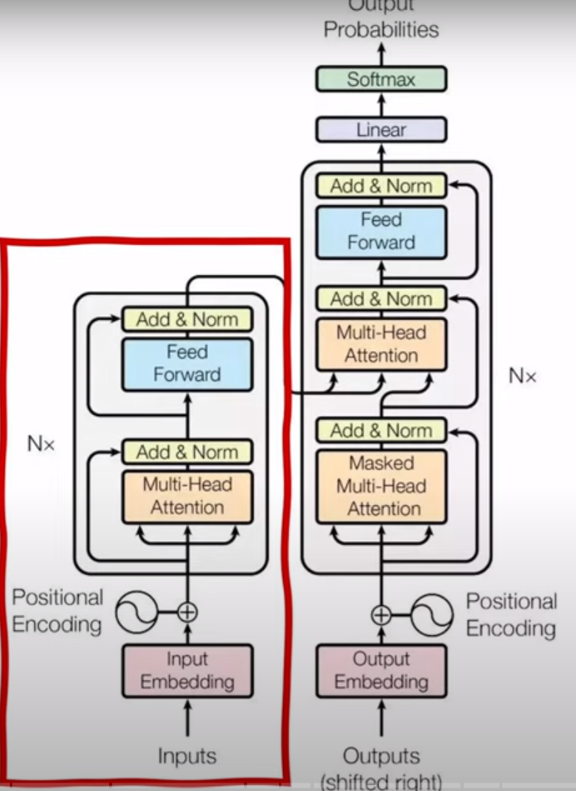

Vision Transformer is simply an extension of Transformer for image data. It only makes use of the left part - encoder (Decoder is mainly use for sequential generative applications such as generating text.)

In [3]:
class PatchEncoder(Layer):
    def __init__(self, N_PATCHES, HIDDEN_SIZE):
        super(PatchEncoder, self).__init__(name = 'patch_encoder')
        
        self.linear_projection = Dense(HIDDEN_SIZE)
        self.positional_embedding = Embedding(N_PATCHES, HIDDEN_SIZE)
        self.N_PATCHES = N_PATCHES
        
    def call(self, x):
        patches = tf.image.extract_patches(
            images = x,
            sizes=[1,16,16,1],
            strides=[1,16,16,1],
            rates=[1,1,1,1],
            padding='VALID')
        patches = tf.reshape(patches, (tf.shape(patches)[0], 256, patches.shape[-1]))
        embedding_input = tf.range(start = 0, limit = self.N_PATCHES, delta = 1)
        output = self.linear_projection(patches) + self.positional_embedding(embedding_input)
        return output

In [4]:
patch_enc = PatchEncoder(256, 768)
patch_enc(tf.zeros([1, 256, 256, 3]))

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[ 0.01168438,  0.04943813, -0.03011848, ...,  0.04873626,
         -0.01262057, -0.00268917],
        [-0.00500858,  0.04647398,  0.04960251, ..., -0.01137514,
          0.02184017, -0.03709291],
        [-0.00845472, -0.04603419,  0.02863337, ..., -0.03996152,
          0.03761089,  0.03778755],
        ...,
        [-0.02692152,  0.04275372,  0.04078163, ...,  0.01286092,
         -0.00194871, -0.04234656],
        [ 0.00974388, -0.04487463,  0.00020515, ...,  0.04865155,
          0.02944141,  0.02682057],
        [ 0.03493135, -0.03632693,  0.0282519 , ...,  0.02809053,
         -0.04676521, -0.02613697]]], dtype=float32)>

In [5]:
class TransformerEncoder(Layer):
    def __init__(self, N_HEADS, HIDDEN_SIZE):
        super(TransformerEncoder, self).__init__()
        
        self.layer_norm_1 = LayerNormalization()
        self.layer_norm_2 = LayerNormalization()
        self.multi_head_att = MultiHeadAttention(N_HEADS, HIDDEN_SIZE)
        self.dense_1 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
        self.dense_2 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
        
        
    def call(self, input):
        x_1 = self.layer_norm_1(input)
        x_1 = self.multi_head_att(x_1, x_1)
        x_1 = Add()([x_1, input])
        
        x_2 = self.layer_norm_2(x_1)
        x_2 = self.dense_1(x_2)
        output = self.dense_2(x_2)
        output = Add()([output, x_1])
        return output

In [6]:
trans_enc = TransformerEncoder(8, 768)
trans_enc(tf.zeros([1, 256, 768]))

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [7]:
resize_rescale_layer = tf.keras.Sequential([
    Resizing(CONFIGURATION['IMG_SIZE'], CONFIGURATION['IMG_SIZE']),
    Rescaling(1./255)
#     Permute((3,1,2))
])

In [8]:
def build_vit(N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS):
    inputs = Input(shape = (CONFIGURATION['IMG_SIZE'], CONFIGURATION['IMG_SIZE'], 3))
    x = resize_rescale_layer(inputs)
    patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE)
    x = patch_encoder(x)
    trans_encoders = [TransformerEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]
    
    for i in range(N_LAYERS):
        x = trans_encoders[i](x)
    
    x = Flatten()(x)
    x = Dense(N_DENSE_UNITS, tf.nn.gelu)(x)
    x = Dense(N_DENSE_UNITS, tf.nn.gelu)(x)
    x = Dense(len(CLASS_NAMES))(x)
    
    model = Model(inputs, x, name='vision_transformer')
    return model


In [9]:
vit = build_vit(
    N_HEADS = 8, HIDDEN_SIZE = 768, N_PATCHES = 256,
    N_LAYERS = 2, N_DENSE_UNITS = 128)
vit(tf.zeros([1,256, 256, 3]))

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[-0.09652933,  0.12613475,  0.42613202, -0.04387612, -0.00142334,
         0.11155357,  0.17987248]], dtype=float32)>

In [10]:
test_image = cv2.imread('/kaggle/input/fer2013/train/happy/Training_10019449.jpg')
test_image = cv2.resize(test_image, (CONFIGURATION['IMG_SIZE'], CONFIGURATION['IMG_SIZE']))
vit(tf.expand_dims(test_image, axis = 0))

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[-0.58610004,  0.24189386,  0.9930445 , -0.38904357,  0.40867877,
        -0.4410375 , -0.58818144]], dtype=float32)>

In [11]:
vit.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 patch_encoder (PatchEncoder  (None, 256, 768)         787200    
 )                                                               
                                                                 
 transformer_encoder_1 (Tran  (None, 256, 768)         20077824  
 sformerEncoder)                                                 
                                                                 
 transformer_encoder_2 (Tran  (None, 256, 768)         20077824  
 sformerEncoder)                                                 
                                                

In [14]:
# Compile the model
vit.compile(
    optimizer=Adam(learning_rate=1e-5),  # Set the learning rate
    loss=CategoricalCrossentropy(from_logits=True),  # Use CategoricalCrossentropy as loss function
    metrics=[CategoricalAccuracy(), TopKCategoricalAccuracy(k=5)]  # Monitor accuracy and top-5 accuracy
)

# Define callbacks
# Save the best model based on validation loss
model_checkpoint_callback = ModelCheckpoint(
    filepath='/kaggle/working/best_vit_scratch_model.keras',  # Adjust the path as necessary
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# Train the model
history = vit.fit(
    train_dataset,  # Training dataset
    validation_data=val_dataset,  # Validation dataset
    epochs=10,  # Number of epochs to train
    callbacks=[model_checkpoint_callback]  # List of callbacks
)


Epoch 1/10
718/718 [==============================] - 326s 440ms/step - loss: 1.7262 - categorical_accuracy: 0.3108 - top_k_categorical_accuracy: 0.9076 - val_loss: 1.6406 - val_categorical_accuracy: 0.3630 - val_top_k_categorical_accuracy: 0.9185
Epoch 2/10
718/718 [==============================] - 316s 440ms/step - loss: 1.5945 - categorical_accuracy: 0.3802 - top_k_categorical_accuracy: 0.9351 - val_loss: 1.5688 - val_categorical_accuracy: 0.3905 - val_top_k_categorical_accuracy: 0.9364
Epoch 3/10
718/718 [==============================] - 316s 440ms/step - loss: 1.5017 - categorical_accuracy: 0.4232 - top_k_categorical_accuracy: 0.9467 - val_loss: 1.5460 - val_categorical_accuracy: 0.4052 - val_top_k_categorical_accuracy: 0.9389
Epoch 4/10
718/718 [==============================] - 316s 440ms/step - loss: 1.3949 - categorical_accuracy: 0.4730 - top_k_categorical_accuracy: 0.9567 - val_loss: 1.5241 - val_categorical_accuracy: 0.4257 - val_top_k_categorical_accuracy: 0.9422
Epoch 5/

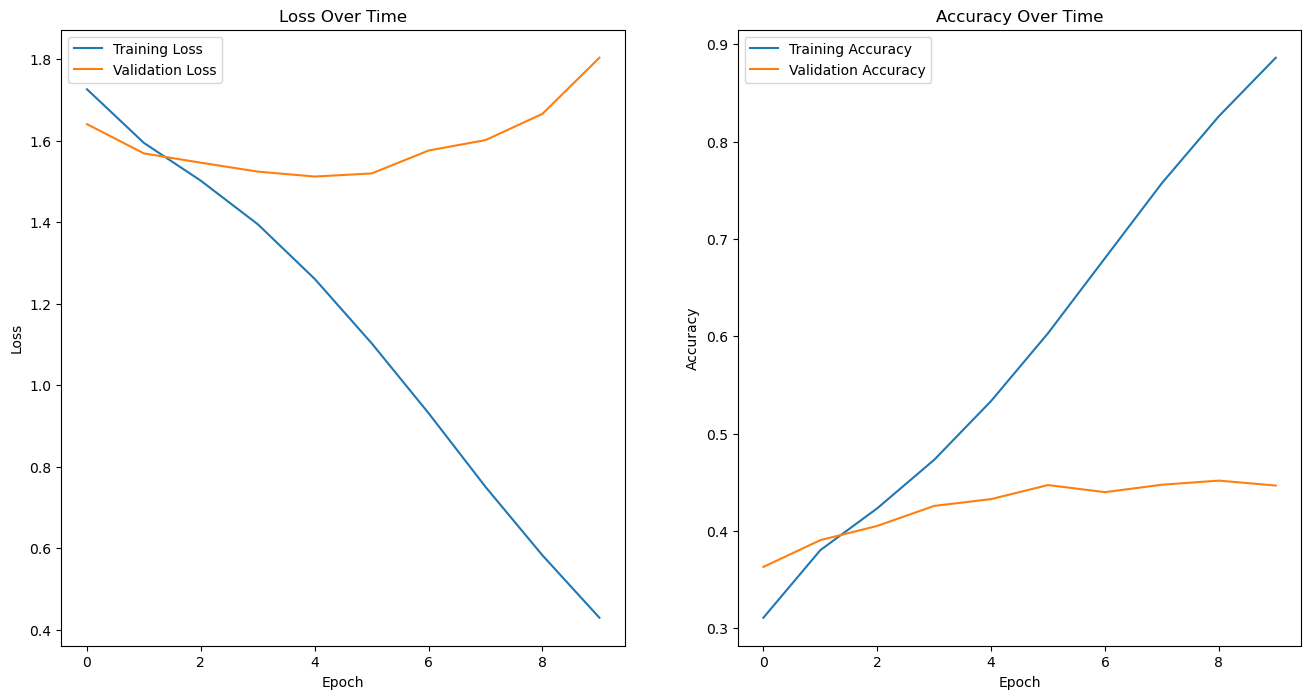

In [15]:
# Plot training history
# This will help you visualize the training and validation accuracy and loss over epochs.
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.legend()

plt.show()

In [16]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix

actual_labels = []
predicted_labels = []

for images, labels in test_dataset:
    # Get model predictions
    preds = vit.predict(images)
    # Convert predictions to label indices
    pred_labels = np.argmax(preds, axis=1)
    actual_labels.extend(np.argmax(labels.numpy(), axis=1))
    predicted_labels.extend(pred_labels)

# Convert lists to numpy arrays for compatibility with sklearn metrics
actual_labels = np.array(actual_labels)
predicted_labels = np.array(predicted_labels)
# Calculate accuracy
accuracy = CategoricalAccuracy()
accuracy.update_state(actual_labels, predicted_labels)
test_accuracy = accuracy.result().numpy()

# Calculate precision, recall, and F1-score
report = classification_report(actual_labels, predicted_labels, target_names=CLASS_NAMES, output_dict=True)

print(classification_report(actual_labels, predicted_labels, target_names=CLASS_NAMES))

# If you want to access individual values, you can do it like this:
for class_name in CLASS_NAMES:
    class_report = report[class_name]
    print(f"Class: {class_name}")
    print(f"Precision: {class_report['precision']}")
    print(f"Recall: {class_report['recall']}")
    print(f"F1-Score: {class_report['f1-score']}")

1/1 [==============================] - 0s 463ms/step
              precision    recall  f1-score   support

       angry       0.37      0.26      0.30       958
     disgust       0.62      0.18      0.28       111
        fear       0.36      0.30      0.33      1024
       happy       0.62      0.63      0.62      1774
     neutral       0.40      0.40      0.40      1233
         sad       0.33      0.44      0.38      1247
    surprise       0.56      0.63      0.60       831

    accuracy                           0.45      7178
   macro avg       0.47      0.41      0.41      7178
weighted avg       0.45      0.45      0.45      7178

Class: angry
Precision: 0.3744292237442922
Recall: 0.2567849686847599
F1-Score: 0.3046439628482972
Class: disgust
Precision: 0.625
Recall: 0.18018018018018017
F1-Score: 0.2797202797202797
Class: fear
Precision: 0.36330935251798563
Recall: 0.2958984375
F1-Score: 0.32615715823466096
Class: happy
Precision: 0.6195230171935663
Recall: 0.629650507328072

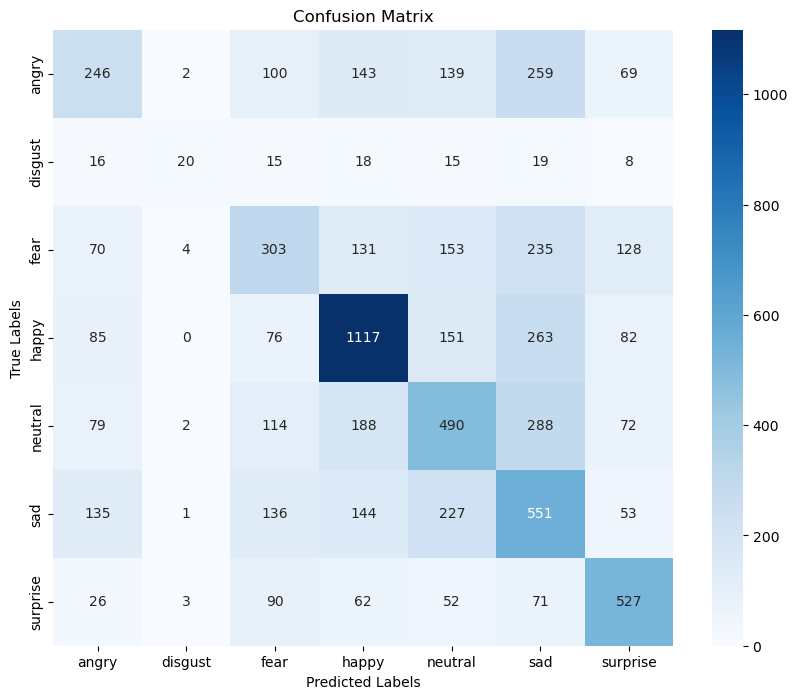

In [17]:

# Calculate the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Fine-tuning pretrained Vision Transformer

In [11]:
resize_rescale_permute = tf.keras.Sequential([
    Resizing(224, 224),
    Permute((3,1,2))
])

In [12]:
base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs = Input(shape = (CONFIGURATION['IMG_SIZE'], CONFIGURATION['IMG_SIZE'], 3))
x = resize_rescale_permute(inputs)
x = base_model.vit(x)[0][:,0,:] ## Only get the last hidden state and the class embedding
x = Dropout(0.3)(x)
output = Dense(len(CLASS_NAMES), activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
hf_model = tf.keras.Model(inputs=inputs, outputs=output)

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [13]:
test_image = cv2.imread('/kaggle/input/fer2013/train/happy/Training_10019449.jpg')
test_image = cv2.resize(test_image, (CONFIGURATION['IMG_SIZE'], CONFIGURATION['IMG_SIZE']))

In [14]:
hf_model(tf.expand_dims(test_image, axis = 0)).shape

TensorShape([1, 7])

In [15]:
hf_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPoo  86389248  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0     

In [17]:
# Compile the model
hf_model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Set the learning rate
    loss=CategoricalCrossentropy(from_logits=True),  # Use CategoricalCrossentropy as loss function
    metrics=[CategoricalAccuracy(), TopKCategoricalAccuracy(k=5)]  # Monitor accuracy and top-5 accuracy
)

# Define callbacks
# Save the best model based on validation loss
model_checkpoint_callback = ModelCheckpoint(
    filepath='/kaggle/working/best_model.keras',  # Adjust the path as necessary
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# Train the model
history = hf_model.fit(
    train_dataset,  # Training dataset
    validation_data=val_dataset,  # Validation dataset
    epochs=10,  # Number of epochs to train
    callbacks=[model_checkpoint_callback]  # List of callbacks
)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1263/1263 [==============================] - 1013s 767ms/step - loss: 1.3562 - categorical_accuracy: 0.5502 - top_k_categorical_accuracy: 0.9588 - val_loss: 1.0462 - val_categorical_accuracy: 0.6758 - val_top_k_categorical_accuracy: 0.9900
Epoch 2/10
1263/1263 [==============================] - 964s 763ms/step - loss: 0.9659 - categorical_accuracy: 0.6980 - top_k_categorical_accuracy: 0.9921 - val_loss: 0.8950 - val_categorical_accuracy: 0.7237 - val_top_k_categorical_accuracy: 0.9948
Epoch 3/10
1263/1263 [==============================] - 963s 762ms/step - loss: 0.8307 - categorical_accuracy: 0.7481 - top_k_categorical_accuracy: 0.9953 - val_loss: 0.8321 - val_categorical_accuracy: 0.7482 - val_top_k_categorical_accuracy: 0.9958
Epoch 4/10
1263/1263 [==============================] - 965s 763ms/step - loss: 0.7356 - categorical_accuracy: 0.7859 - top_k_categorical_accuracy: 0.9970 - val_loss: 0.7634 - val_categorical_accuracy: 0.7734 - val_top_k_categorical_accuracy: 0.9961
Epoch 5/10

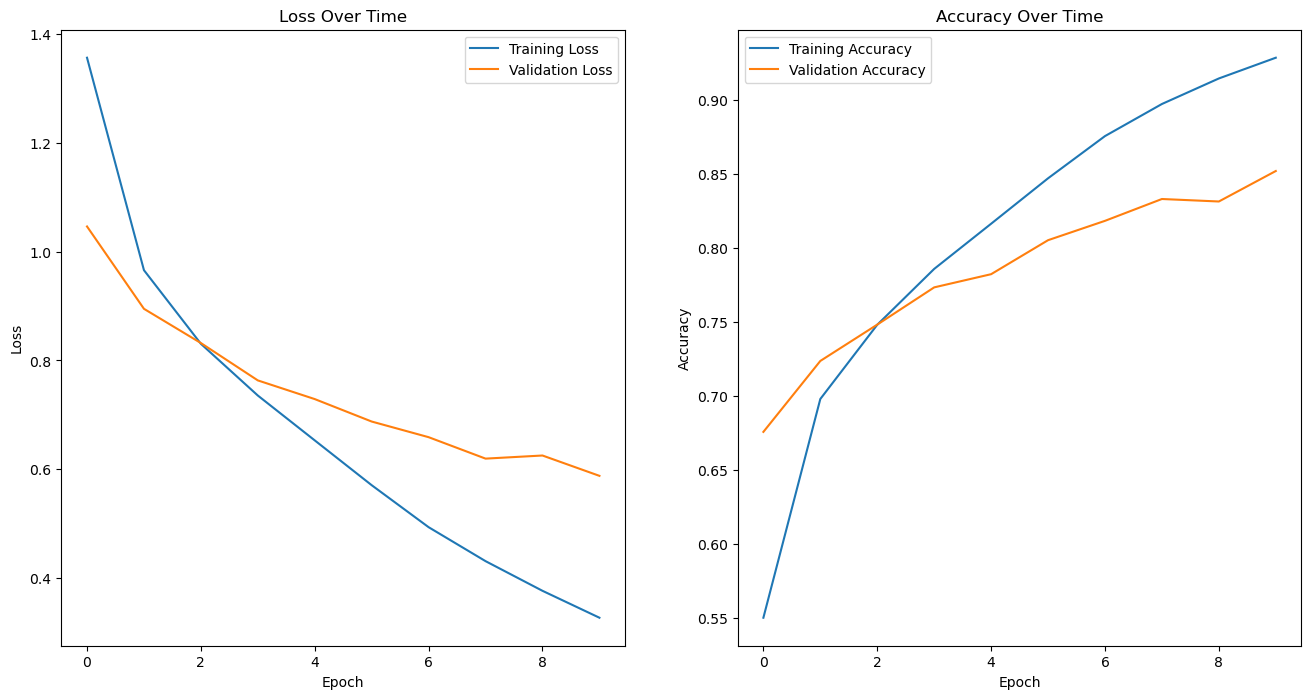

In [18]:
# Plot training history
# This will help you visualize the training and validation accuracy and loss over epochs.
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.legend()
plt.show()

In [22]:
# Evaluate the model
results = hf_model.evaluate(val_dataset, steps=int(np.ceil(val_dataset.samples // val_dataset.batch_size)))

315/315 [==============================] - 81s 256ms/step - loss: 0.5886 - categorical_accuracy: 0.8519 - top_k_categorical_accuracy: 0.9947


In [38]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For a nicer-looking matrix


actual_labels = test_dataset.labels


# Generate predictions for the validation set
predictions = hf_model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

225/225 [==============================] - 56s 250ms/step


In [39]:
predicted_labels

array([2, 0, 0, ..., 6, 6, 6])

In [40]:
# Convert lists to numpy arrays for compatibility with sklearn metrics
actual_labels = np.array(actual_labels)
predicted_labels = np.array(predicted_labels)
# Calculate accuracy
accuracy = CategoricalAccuracy()
accuracy.update_state(actual_labels, predicted_labels)
test_accuracy = accuracy.result().numpy()

# Calculate precision, recall, and F1-score
report = classification_report(actual_labels, predicted_labels, target_names=CLASS_NAMES, output_dict=True)

print(classification_report(actual_labels, predicted_labels, target_names=CLASS_NAMES))

# If you want to access individual values, you can do it like this:
for class_name in CLASS_NAMES:
    class_report = report[class_name]
    print(f"Class: {class_name}")
    print(f"Precision: {class_report['precision']}")
    print(f"Recall: {class_report['recall']}")
    print(f"F1-Score: {class_report['f1-score']}")

              precision    recall  f1-score   support

       angry       0.66      0.59      0.62       958
     disgust       0.71      0.72      0.71       111
        fear       0.57      0.55      0.56      1024
       happy       0.87      0.90      0.89      1774
     neutral       0.65      0.68      0.67      1233
         sad       0.58      0.59      0.59      1247
    surprise       0.83      0.82      0.82       831

    accuracy                           0.71      7178
   macro avg       0.70      0.69      0.69      7178
weighted avg       0.70      0.71      0.70      7178

Class: angry
Precision: 0.6576787807737398
Recall: 0.5855949895615866
F1-Score: 0.6195472114853672
Class: disgust
Precision: 0.7079646017699115
Recall: 0.7207207207207207
F1-Score: 0.7142857142857142
Class: fear
Precision: 0.5672690763052208
Recall: 0.5517578125
F1-Score: 0.5594059405940593
Class: happy
Precision: 0.8741105637657361
Recall: 0.9002254791431793
F1-Score: 0.8869758400444321
Class: neutr

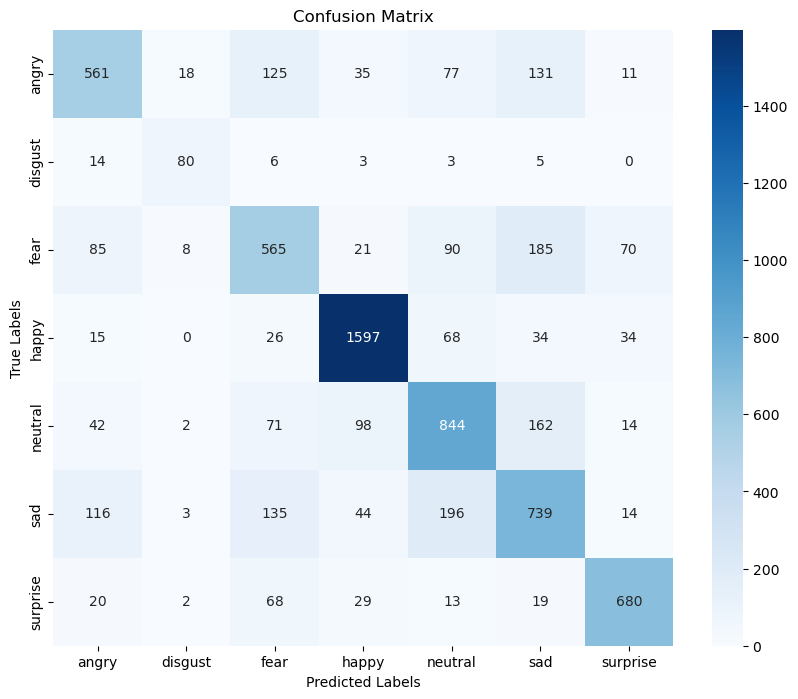

In [41]:

# Calculate the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()